In [2]:
!pip install GPy
!pip install scikit-activeml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 8.0 MB/s eta 0:00:00
  Using cached iteration_utilities-0.11.0-cp38-cp38-manylinux2014_x86_64.whl (344 kB)


In [3]:
import GPy
import numpy as np
import pylab as plt

from skactiveml.utils import unlabeled_indices, labeled_indices

In [38]:
def weighted_avg_and_std(values, weights, **kwargs):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    return (average, np.sqrt(variance))

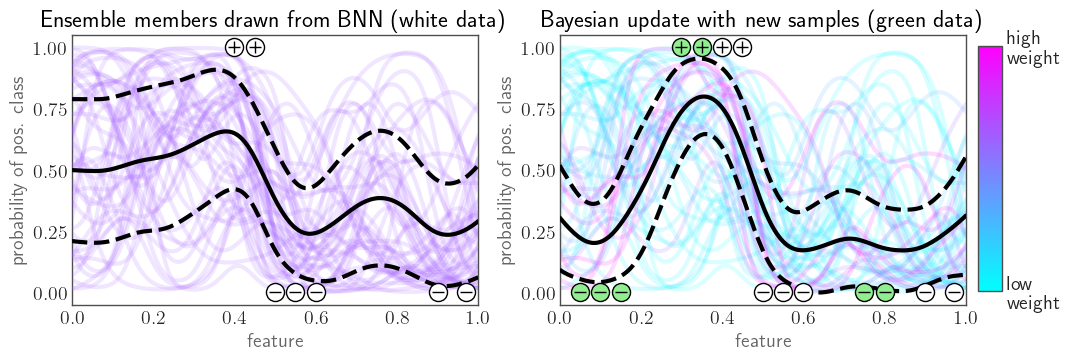

In [58]:
from GPy.likelihoods import Gaussian
from GPy.likelihoods.link_functions import Identity
lik_id = Gaussian(Identity(), 1e-9) 
# standard model

X = np.array([.4, .45, .5, .55, .6, .9, .97]).reshape(-1, 1)
y = np.array([ 1,   1,  0,   0,  0,  0,   0]).reshape(-1, 1)

X_add = np.array([.05, .1, .15, .3, .35,.75, .8]).reshape(-1, 1)
y_add = np.array([  0,  0,   0,  1,   1,  0,  0]).reshape(-1, 1)

lik_bernoulli = GPy.likelihoods.Bernoulli()

m = GPy.core.GP(X=X,
                Y=y, 
                kernel=GPy.kern.RBF(1, variance=1, lengthscale=0.1), 
                inference_method=GPy.inference.latent_function_inference.expectation_propagation.EP(),
                likelihood=lik_bernoulli)


n_base_functions = 200

x_axis = np.linspace(0,1,201).reshape(-1,1)
X_all = np.vstack([x_axis, X_add])

post_f = m.posterior_samples_f(X_all, size=n_base_functions)
post_prob = m.likelihood.gp_link.transf(post_f)[:,:,:]
weights_old = np.ones(n_base_functions) / n_base_functions
weights_new = np.ones(n_base_functions) / n_base_functions
prob_axis = post_prob[:len(x_axis)]
prob_add = post_prob[len(x_axis):]

weights_new = np.array(weights_old)
for X_, y_, p in zip(X_add, y_add, prob_add):
    if y_ == 1:
        weights_new *= p[0]
    else:
        weights_new *= 1-p[0]
weights_new /= np.sum(weights_new)

fig = plt.figure(figsize=(12,3.5))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
for i, weights, X_a, y_a in [(1, weights_old, np.empty([0,1]), np.empty([0,1])), (2, weights_new, X_add, y_add)]:
    plt.subplot(1,2,i)
    for j, (X_, y_) in enumerate([(X, y), (X_a, y_a)]):
        plt.plot(X_, y_, 'o', color='w' if j==0 else 'lightgreen', markersize=13, mec='k', zorder=202)
        plt.plot(X_[y_==1], y_[y_==1], '+', markersize=8, mec='k', zorder=202)
        plt.plot(X_[y_==0], y_[y_==0], '_', markersize=8, mec='k', zorder=202)
    
    alphas = weights**.6
    alphas = alphas / np.max(weights)
    for j, (p, a) in enumerate(zip(prob_axis[:,0,:50].T, alphas)):
        #plt.plot(x_axis.reshape(-1), p, 'g-', lw=3, alpha=.05*i**2.5*a)
        if i==1:
            plt.plot(x_axis.reshape(-1), p, '-', color=plt.cm.cool(a/13), lw=3, alpha=.15, zorder=a)
        if i==2:
            plt.plot(x_axis.reshape(-1), p, '-', color=plt.cm.cool(a), lw=3, alpha=.15, zorder=a)
    #plt.plot(x_axis.reshape(-1), np.average(prob_axis[:,0,:], weights=weights, axis=1), 'k-', lw=3, alpha=1)
    average = np.average(prob_axis[:, 0, :], weights=weights, axis=1)
    std = np.sqrt(np.average((prob_axis[:, 0, :]-average[:, None])**2, weights=weights, axis=1))
    
    if i==1:
        ax1.plot(x_axis.reshape(-1), average, 'k-', lw=3, alpha=1, zorder=201)
        ax1.plot(x_axis.reshape(-1), average-std, 'k--', lw=3, alpha=1, zorder=201)
        ax1.plot(x_axis.reshape(-1), average+std, 'k--', lw=3, alpha=1, zorder=201)
    if i==2:
        ax2.plot(x_axis.reshape(-1), average, 'k-', lw=3, alpha=1, zorder=201)
        ax2.plot(x_axis.reshape(-1), average-std, 'k--', lw=3, alpha=1, zorder=201)
        ax2.plot(x_axis.reshape(-1), average+std, 'k--', lw=3, alpha=1, zorder=201)

    plt.yticks(np.linspace(0,1,5))
#     plt.ylabel('$p(y=+|x)$');plt.xlabel('$x$')
    plt.ylabel('probability of pos. class');plt.xlabel('feature')
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    plt.grid()
    plt.xlim([0, 1])
    if i==1:
        plt.title('Ensemble members drawn from BNN (white data)')
    else:
        plt.title('Bayesian update with new samples (green data)')
        fig.subplots_adjust(right=0.87)
        cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
        cb = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=None, cmap=plt.cm.cool), ticks=[0, 1], cax=cbar_ax)
        #cb = plt.colorbar(cmap='Dark2', ticks=np.linspace(0.5/9, 3.5/9, 4), boundaries=np.linspace(0,4/9,5), label='weight', )
        cb.set_ticklabels(['low\nweight', 'high\nweight'])
plt.savefig('graph_abstract.pdf', bbox_inches='tight')
plt.show()